In [4]:
!pip install pandas
!pip install scikit-learn
!pip install xgboost
!pip install yfinance
!pip install matplotlib

In [5]:
import yfinance as yf
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from xgboost import XGBClassifier
     


<Axes: xlabel='Date'>

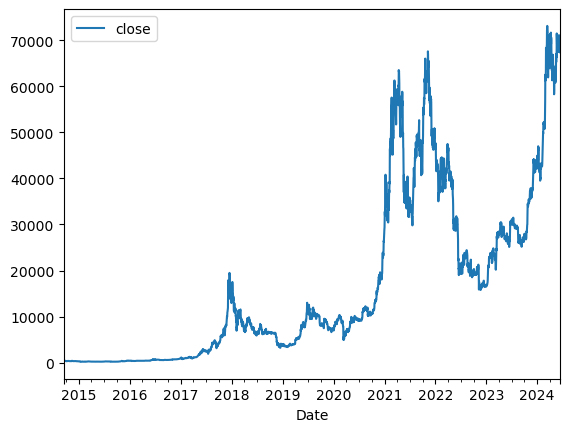

In [6]:
btc_ticker = yf.Ticker("BTC-USD")
btc = btc_ticker.history(period="max")
btc.index = pd.to_datetime(btc.index)
del btc["Dividends"]
del btc["Stock Splits"]
btc.columns = [c.lower() for c in btc.columns]
btc.plot.line(y="close", use_index=True)

In [8]:
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)
btc = btc.tz_localize(None)
btc = btc.merge(wiki, left_index=True, right_index=True)

In [9]:
btc["tomorrow"] = btc["close"].shift(-1)
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)
btc["target"].value_counts()

target
1    1884
0    1674
Name: count, dtype: int64

In [10]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

In [11]:
train = btc.iloc[:-200]
test = btc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=50, random_state=1)

In [12]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"],preds)

0.7857142857142857

In [13]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="predictions")
  combined = pd.concat([test["target"], preds], axis=1)
  return combined

In [14]:
def backtest(data, model, predictors, start=1095, step=150):
  all_predictions = []

  for i in range(start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [15]:
model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [16]:
precision_score(predictions["target"], predictions["predictions"])

0.4990341274951706

In [17]:
def compute_rolling(btc):
  horizons = [2,7,60,365]
  new_predictors = ["close", "sentiment", "neg_sentiment"]

  for horizon in horizons:
    rolling_averages = btc.rolling(horizon, min_periods=1).mean()
    ratio_column = f"close_ratio_{horizon}"
    btc[ratio_column] = btc["close"] / rolling_averages["close"]
    edit_column = f"edit_{horizon}"
    btc[edit_column] = rolling_averages["edit_count"]
    rolling = btc.rolling(horizon, closed="left", min_periods=1).mean()
    trend_column = f"trend_{horizon}"
    btc[trend_column] = rolling["target"]
    new_predictors += [ratio_column, trend_column, edit_column]

  return btc, new_predictors

In [18]:
btc, new_predictors = compute_rolling(btc.copy())

In [19]:
predictions = backtest(btc, model, new_predictors)
precision_score(predictions["target"], predictions["predictions"])

0.5282574568288854